# 5.2) 구매 기록 기반 상품 추천하기

In [36]:
# -*- coding: utf-8 -*-

%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# <Step1. 탐색적 분석> : UK Retail 데이터 분석하기

### UK Retail 데이터셋의 기본 정보

#### 데이터 피처 설명
- InvoiceNo : 거래 고유 번호
- StockCode : 상품 고유 번호
- Description : 상품명
- Quantity : 거래 수량
- InvoiceDate : 거래 일시
- UnitPrice : 상품 단가
- CustomerID : 구매자 고유 번호
- Country : 구매 국가

-----

### 1. About Data

In [37]:
# 영국 선물샵 온라인 도매 거래 데이터
df = pd.read_csv("../data/online_retail.csv", dtype={'CustomerID': str,'InvoiceID': str}, encoding="ISO-8859-1")

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  object 
 7   Country      541909 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 33.1+ MB


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom


In [38]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format="%m/%d/%Y %H:%M") # format에 들어가있는거는 변화 후가 아닌 변화 전 형식!

print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  object        
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 33.1+ MB
None


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


-----

### 2. 전처리

#### 1) 결측데이터 제거

In [39]:
df.isnull().sum() # 각 col별로 결측치가 몇 개 있는지?

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [40]:
df = df.dropna() # 결측치 제거
print(df.shape) # (541909, 8) -> (406829, 8)

(406829, 8)


-----

#### 2) 일반적이지 않은 상품 제거

In [41]:
# 상품수량이 음수인 경우를 제거합니다.
print(df[df['Quantity']<=0].shape[0])
df = df[df['Quantity']>0]

8905


In [42]:
# 상품 가격이 음수인 경우를 제거합니다.
print(df[df['UnitPrice']<=0].shape[0])
df = df[df['UnitPrice']>0]

40


In [43]:
# 상품 코드가 일반적이지 않은 경우(번호가 아닌 경우)를 탐색합니다.
df['ContainDigit'] = df['StockCode'].apply(lambda x: any(c.isdigit() for c in x))
print(df[df['ContainDigit'] == False].shape[0]) # 1414개나 있음
df[df['ContainDigit'] == False].head() # ContainDigit가 일반적이지 않은 경우

1414


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,ContainDigit
45,536370,POST,POSTAGE,3,2010-12-01 08:45:00,18.00,12583,France,False
386,536403,POST,POSTAGE,1,2010-12-01 11:27:00,15.00,12791,Netherlands,False
1123,536527,POST,POSTAGE,1,2010-12-01 13:04:00,18.00,12662,Germany,False
2239,536569,M,Manual,1,2010-12-01 15:35:00,1.25,16274,United Kingdom,False
2250,536569,M,Manual,1,2010-12-01 15:35:00,18.95,16274,United Kingdom,False


In [44]:
# 상품 코드가 일반적이지 않은 경우를 제거합니다.
df = df[df['ContainDigit'] == True]

-----

### 3. 탐색적 데이터 분석

#### 1) 일자별 거래 데이터 분석

In [48]:
df['date'] = df['InvoiceDate'].dt.date # YYYY-MM-DD 형식으로 출력

print(df['date'].min()) # 가장 오래된 날짜
print(df['date'].max()) # 가장 최근의 날짜

2010-12-01
2011-12-09


datetime .. https://m.blog.naver.com/PostView.naver?isHttpsRedirect=true&blogId=wideeyed&logNo=221603462366

<AxesSubplot: xlabel='date'>

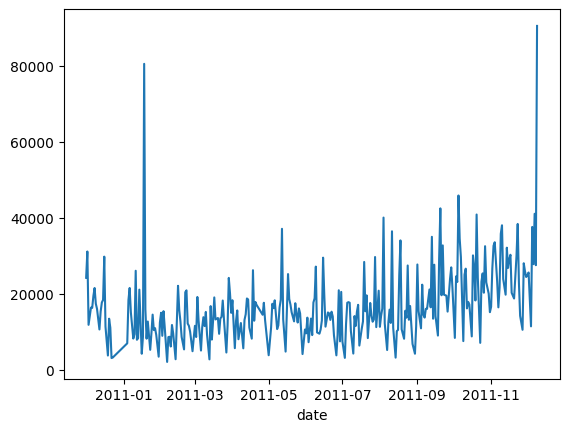

In [49]:
# 일자별 총 거래 수량을 탐색합니다.
date_quantity_series = df.groupby('date')['Quantity'].sum()
date_quantity_series.plot()

(1) 일자별 총 거래 횟수

<AxesSubplot: xlabel='date'>

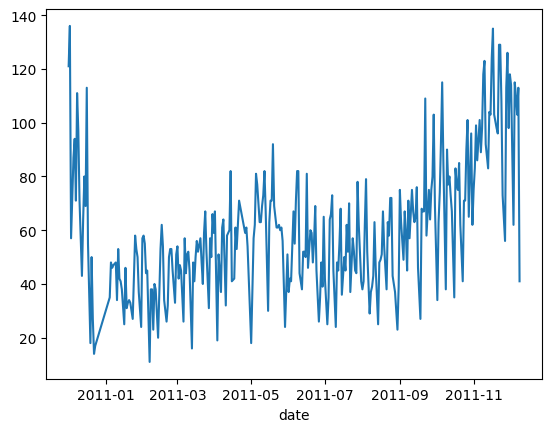

In [53]:
# 일자별 총 거래 횟수를 탐색합니다.
date_transaction_series = df.groupby('date')['InvoiceNo'].nunique()
date_transaction_series.plot()

(2) 일자별 상품 거래 다양성

<AxesSubplot: xlabel='date'>

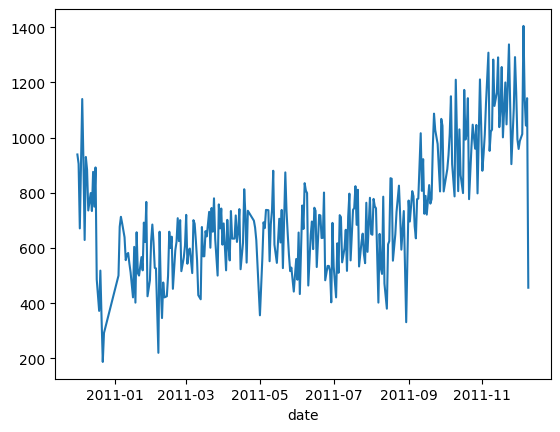

In [54]:
# 일자별 거래된 상품의 unique한 갯수, 즉 상품 거래 다양성을 탐색합니다.
date_unique_item_series = df.groupby('date')['StockCode'].nunique()
date_unique_item_series.plot()

-----

#### 2) 유저별 구매 패턴 분석

(1) 유저별 거래 횟수

In [56]:
# 총 유저의 수를 계산하여 출력합니다.
print(len(df['CustomerID'].unique()))

4334


In [60]:
customer_unique_transaction_series = df.groupby('CustomerID')['InvoiceNo'].nunique()
customer_unique_transaction_series.describe() # 기술통계량

count    4334.000000
mean        4.246654
std         7.642535
min         1.000000
25%         1.000000
50%         2.000000
75%         5.000000
max       206.000000
Name: InvoiceNo, dtype: float64

유저들은 평균적으로 4회 정도의 구매가 있었음

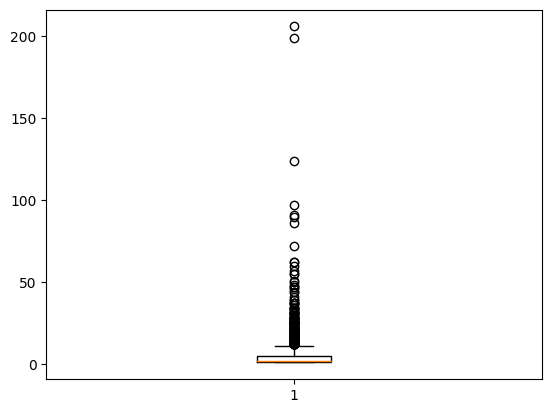

In [58]:
# 시각화 (상자그림)
plt.boxplot(customer_unique_transaction_series.values)
plt.show()

(2) 유저벌 아이템 구매 종류 개수

In [59]:
customer_unique_item_series = df.groupby('CustomerID')['StockCode'].nunique()
customer_unique_item_series.describe()

count    4334.000000
mean       61.432856
std        85.312937
min         1.000000
25%        16.000000
50%        35.000000
75%        77.000000
max      1786.000000
Name: StockCode, dtype: float64

유저들은 평균적으로 60여 개 종류의 상품을 구매

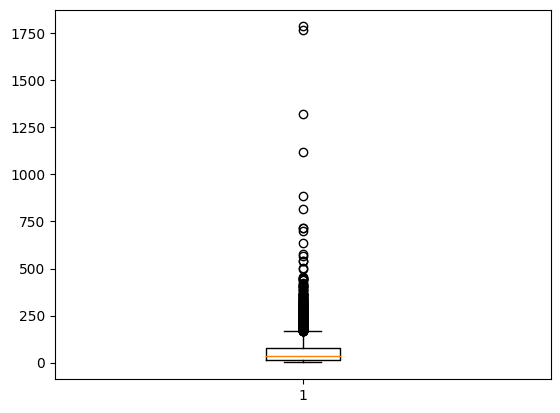

In [61]:
# 시각화(상자그림)
plt.boxplot(customer_unique_item_series.values)
plt.show()

---------------

### `[미니 퀴즈 - 5.2]`
- `이번에는 유저가 아닌 상품을 기준으로 EDA를 실시해 보세요.` 
    - 아래의 내용들을 탐색적으로 분석해보도록 합시다.
        - 총 상품 갯수
        - 가장 거래가 많은 상품 top 10 탐색
        - 상품별 판매수량 분포 탐색
        - 거래별 가격 탐색

#### Q1) 총 상품 갯수

In [66]:
print(len(df['StockCode'].unique()))
# df['StockCode'].nunique()

3660


#### Q2) 거래횟수 top 10 상품

In [67]:
df.groupby('StockCode')['InvoiceNo'].nunique().sort_values(ascending=False)[:10]

StockCode
85123A    1978
22423     1703
85099B    1600
47566     1379
84879     1375
20725     1289
22720     1146
23203     1080
20727     1052
22383     1043
Name: InvoiceNo, dtype: int64

#### Q3) 상품별 판매수량 분포

count     3660.000000
mean      1409.149727
std       3513.654056
min          1.000000
25%         65.000000
50%        395.000000
75%       1417.500000
max      80995.000000
Name: Quantity, dtype: float64


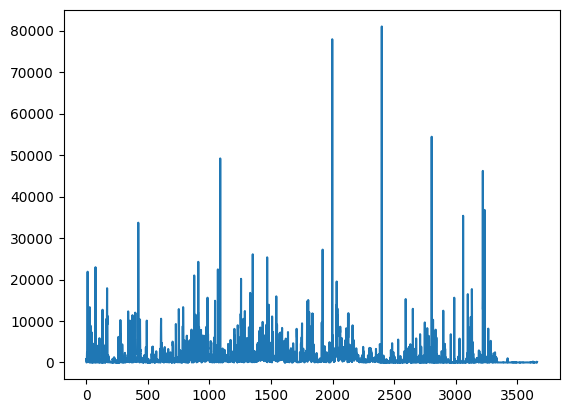

In [69]:
print(df.groupby('StockCode')['Quantity'].sum().describe())

# 분포를 위한 시각화
plt.plot(df.groupby('StockCode')['Quantity'].sum().values)
plt.show()

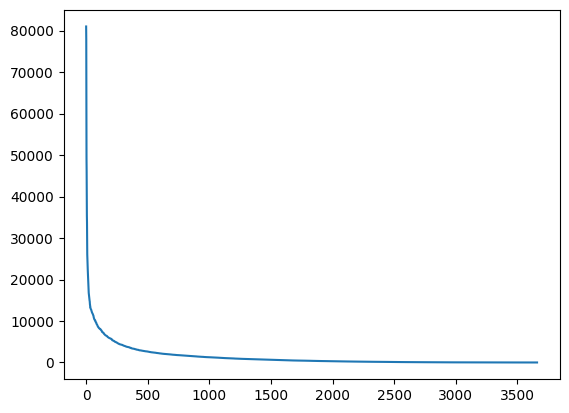

In [70]:
# 참조 : 감소함수로 정렬하여 출력하기
plt.plot(df.groupby('StockCode')['Quantity'].sum().sort_values(ascending=False).values)
plt.show()

#### Q4) 거래별 가격

In [71]:
df['amount'] = df['Quantity'] * df['UnitPrice'] # 총 가격
df.groupby('InvoiceNo')['amount'].sum().describe()

count     18405.000000
mean        476.378845
std        1678.749892
min           0.380000
25%         157.900000
50%         302.360000
75%         465.700000
max      168469.600000
Name: amount, dtype: float64

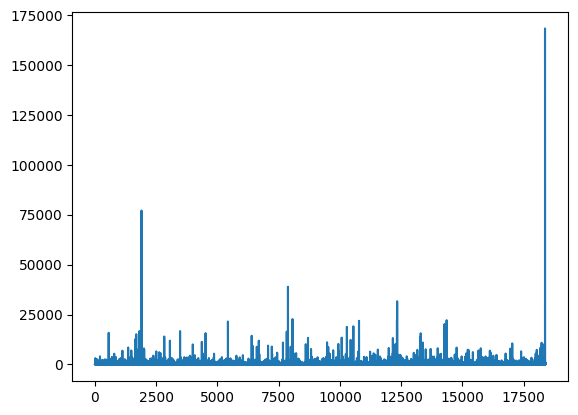

In [72]:
# 시각화
plt.plot(df.groupby('InvoiceNo')['amount'].sum().values)
plt.show()

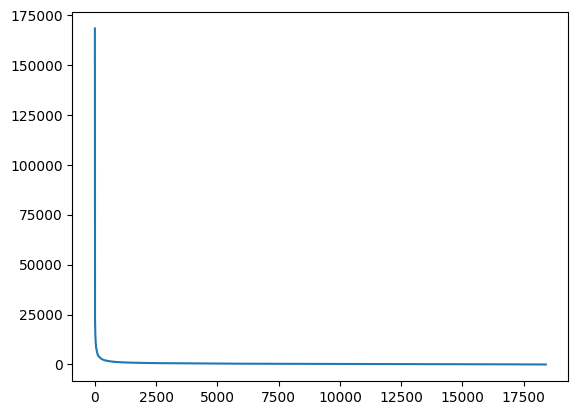

In [73]:
# 참조 : 감소함수로 정렬하여 출력
plt.plot(df.groupby('InvoiceNo')['amount'].sum().sort_values(ascending=False).values)
plt.show()

-----

### 4. 시계열 기준으로 데이터 분리

특정 시점을 기준으로 데이터를 분리하여 데이터를 분석!

In [74]:
df['date']

0         2010-12-01
1         2010-12-01
2         2010-12-01
3         2010-12-01
4         2010-12-01
             ...    
541904    2011-12-09
541905    2011-12-09
541906    2011-12-09
541907    2011-12-09
541908    2011-12-09
Name: date, Length: 396470, dtype: object

#### 1) 2011년 11월을 기준

In [75]:
import datetime

df_year_round = df[df['date'] < datetime.date(2011, 11, 1)] # 2011년 11월 전
df_year_end = df[df['date'] >= datetime.date(2011, 11, 1)] # 2011년 11월 후

print(df_year_round.shape)
print(df_year_end.shape)

(314902, 11)
(81568, 11)


추후 예측 때 사용할 train, test data로 미리 분리

-----

#### 2) 분리된 데이터에서 구매 패턴 탐색

재구매 및 신규 구매가 어떻게 일어났는가?

In [76]:
# 11월 이전 구매했던 상품의 set data 만들기
customer_item_round_set = df_year_round.groupby('CustomerID')['StockCode'].apply(set)
print(customer_item_round_set)

CustomerID
12346                                              {23166}
12347    {20966, 71477, 23177, 21041, 23308, 23147, 227...
12348    {22437, 21213, 23077, 21977, 21967, 84991, 217...
12350    {22348, 22412, 21864, 79066K, 22620, 22551, 79...
12352    {84050, 22138, 21232, 21380, 23198, 22645, 227...
                               ...                        
18280    {22499, 22467, 22495, 22727, 22358, 22180, 220...
18281    {22467, 23008, 22716, 23007, 23209, 22037, 22028}
18282    {23295, 21109, 22424, 21270, 23187, 21108, 22089}
18283    {22021, 85123A, 22418, 23077, 22963, 22722, 22...
18287    {84920, 23269, 35967, 22421, 85039B, 21232, 23...
Name: StockCode, Length: 3970, dtype: object


집합(set)을 사용하게 되면 중복된 것은 제거되기 때문

In [77]:
# 11월 이전에 구매했는지 혹은 이후에 구매했는지를 유저별로 기록하기 위한 딕셔너리 정의
customer_item_dict = {}

# 11월 이전 : 'old'
for customer_id, stocks in customer_item_round_set.items():
    customer_item_dict[customer_id] = {}
    for stock_code in stocks:
        customer_item_dict[customer_id][stock_code] = 'old'

print(str(customer_item_dict)[:100] + "...")

{'12346': {'23166': 'old'}, '12347': {'20966': 'old', '71477': 'old', '23177': 'old', '21041': 'old'...


In [78]:
# 11월 이후 구매했던 상품의 set data 만들기
customer_item_end_set = df_year_end.groupby('CustomerID')['StockCode'].apply(set)
print(customer_item_end_set)

CustomerID
12347    {23508, 20719, 21064, 23497, 23271, 21731, 230...
12349    {85014A, 85014B, 85053, 23460, 21232, 22554, 2...
12352    {22627, 23089, 23096, 23368, 22668, 21669, 221...
12356                                       {21843, 22423}
12357    {85014A, 21485, 22029, 22890, 21508, 22071, 22...
                               ...                        
18272    {22965, 23198, 20914, 23236, 22722, 23240, 234...
18273                                             {79302M}
18274    {22720, 22423, 84509A, 23243, 21974, 21108, 84...
18282                  {22423, 23175, 23174, 22818, 22699}
18283    {22576, 22418, 23381, 23308, 20718, 23582, 211...
Name: StockCode, Length: 1904, dtype: object


In [79]:
# 11월 이전 : 'old'/ 이후 :'new' / 모두 구매 : 'both'라고 표기합니다.

for customer_id, stocks in customer_item_end_set.items():
    # 11월 이전 구매기록이 있는 유저인지를 체크합니다.
    if customer_id in customer_item_dict:
        for stock_code in stocks:
            # 구매한 적 있는 상품인지를 체크한 뒤, 상태를 표기합니다.
            if stock_code in customer_item_dict[customer_id]:
                customer_item_dict[customer_id][stock_code] = 'both' # true -> true
            else:
                customer_item_dict[customer_id][stock_code] = 'new' # true -> false (신규구매)
    
    # 11월 이전 구매기록이 없는 유저라면 모두 'new'로 표기합니다(신규구매)
    else:
        customer_item_dict[customer_id] = {}
        for stock_code in stocks:
            customer_item_dict[customer_id][stock_code] = 'new'

print(str(customer_item_dict)[:100] + "...")

{'12346': {'23166': 'old'}, '12347': {'20966': 'old', '71477': 'old', '23177': 'old', '21041': 'old'...


In [84]:
customer_item_dict # 이용자별 언제 구매했는지 시기가 나옴

{'12346': {'23166': 'old'},
 '12347': {'20966': 'old',
  '71477': 'old',
  '23177': 'old',
  '21041': 'old',
  '23308': 'old',
  '23147': 'old',
  '22729': 'old',
  '84559B': 'old',
  '22945': 'old',
  '22561': 'old',
  '84625A': 'both',
  '21064': 'both',
  '21636': 'old',
  '84997B': 'old',
  '21791': 'old',
  '23420': 'old',
  '23422': 'old',
  '22212': 'old',
  '22432': 'old',
  '84991': 'old',
  '22195': 'old',
  '22771': 'old',
  '22375': 'old',
  '22492': 'old',
  '22727': 'old',
  '84558A': 'old',
  '23162': 'old',
  '22134': 'old',
  '21265': 'both',
  '85232D': 'old',
  '84997D': 'old',
  '21832': 'old',
  '20665': 'old',
  '22821': 'old',
  '23506': 'both',
  '84625C': 'old',
  '51014C': 'old',
  '22252': 'old',
  '23508': 'both',
  '21171': 'old',
  '23170': 'old',
  '22417': 'old',
  '23084': 'both',
  '22372': 'old',
  '22196': 'old',
  '22772': 'old',
  '84992': 'old',
  '20780': 'old',
  '47580': 'old',
  '85116': 'old',
  '21975': 'old',
  '21578': 'old',
  '22422': 'o

In [88]:
# 'old', 'new', 'both'를 유저별로 탐색하여 데이터 프레임을 생성합니다.(분석할 때는 데이터프레임을 이용하는 것이 편하니까!)
columns = ['CustomerID', 'old', 'new', 'both']
df_order_info = pd.DataFrame(columns=columns)

# 1. 데이터 프레임 생성
for customer_id in customer_item_dict:
    old = 0
    new = 0
    both = 0
    
    # 2. 딕셔너리의 상품 상태(old, new, both)를 체크하여 데이터 프레임에 append 할 수 있는 형태로 처리합니다.
    for stock_code in customer_item_dict[customer_id]:
        status = customer_item_dict[customer_id][stock_code]
        if status == 'old':
            old += 1
        elif status == 'new':
            new += 1
        else:
            both += 1
    
    # 3. df_order_info에 데이터를 append합니다.
    row = [customer_id, old, new, both]
    series = pd.Series(row, index=columns)
    df_order_info = df_order_info.append(series, ignore_index=True)

df_order_info.head()

,CustomerID,old,new,both
0,12346,1,0,0
1,12347,92,3,8
2,12348,21,0,0
3,12350,16,0,0
4,12352,43,12,2


------------------

전체 사용자 수

In [89]:
# 데이터 프레임에서 전체 유저 수(=행의 수)를 출력합니다.
print(df_order_info.shape[0])

4334


신규 상품 구매

In [94]:
print(df_order_info[(df_order_info['old'] > 0) & (df_order_info['new'] > 0)].shape[0])

1446


상품 재구매

In [95]:
print(df_order_info[df_order_info['both'] > 0].shape[0])

1426


In [33]:
# new 피처의 value_counts를 출력하여, 새로운 상품을 얼마나 구매하는지 탐색합니다.
df_order_info['new'].value_counts()

0      2521
1        81
3        73
2        72
8        65
       ... 
108       1
113       1
115       1
116       1
391       1
Name: new, Length: 133, dtype: int64

In [100]:
# 만약 새로운 상품을 구매한다면, 얼마나 많은 종류의 새로운 상품을 구매하는지 탐색합니다.
print(df_order_info['new'].value_counts()[1:].describe())

count    132.000000
mean      13.734848
std       19.130672
min        1.000000
25%        1.000000
50%        5.000000
75%       16.000000
max       81.000000
Name: new, dtype: float64


평균적으로 13개 정도의 새로운 상품을 구매, but 편차가 좀 커보임

-----

# <Step2. 예측 분석> : SVD를 활용한 상품 구매 예측

- Ch3_평점예측과 동일한 방식
    - 특정 시점 이전의 데이터로 SVD 모델 학습
    - 특정 시점 이후의 유저-상품점수 예측

#### 데이터 피처 설명
- InvoiceNo : 거래 고유 번호
- StockCode : 상품 고유 번호
- Description : 상품명
- Quantity : 거래 수량
- InvoiceDate : 거래 일시
- UnitPrice : 상품 단가
- CustomerID : 구매자 고유 번호
- Country : 구매 국가

### 1. 피처 엔지니어링

11월 전 상품을 구매한 사용자 수

In [91]:
# print(len(df_year_round['CustomerID'].unique()))
df_year_round['CustomerID'].nunique()

3970

11월 전 구매된 상품 수

In [92]:
# print(len(df_year_round['StockCode'].unique()))
df_year_round['StockCode'].nunique()

3608

##### Q. 상품점수(Rating)는 어떻게 구함..?

#### A. SVD 모델에 사용할 데이터 : User-Item간의 Rating 생성!

In [103]:
# 유저별 구매 횟수 / 상품별 구매 횟수
uir_df = df_year_round.groupby(['CustomerID', 'StockCode'])['InvoiceNo'].nunique().reset_index() # 원본 객체는 바뀌지 않음
uir_df.head()

,CustomerID,StockCode,InvoiceNo
0,12346,23166,1
1,12347,16008,1
2,12347,17021,1
3,12347,20665,1
4,12347,20719,3


set_index 및 reset_index  ..  https://kongdols-room.tistory.com/123

<AxesSubplot: >

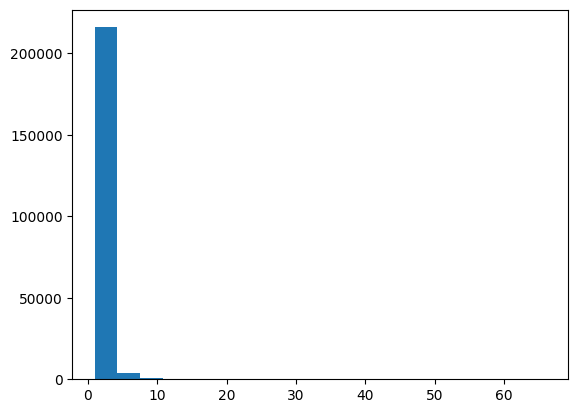

In [106]:
# Rating(InvoiceNo) 피처의 분포를 탐색합니다.
uir_df['InvoiceNo'].hist(bins=20, grid=False)

-----------------------

##### P1 : 구매횟수가 낮은 쪽으로 지나치게 쏠려있음

#### S1 : 로그 피처 정규화!

<AxesSubplot: >

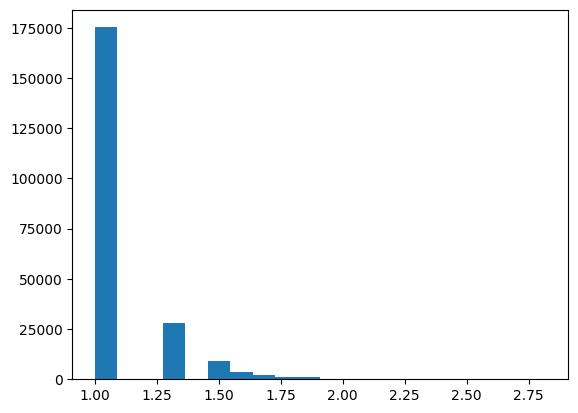

In [107]:
uir_df['InvoiceNo'].apply(lambda x: np.log10(x)+1).hist(bins=20, grid=False)

--------------------

##### P2 : 하지만 아직까지도 부족한 느낌..

#### S2 : min-max scaling

<AxesSubplot: >

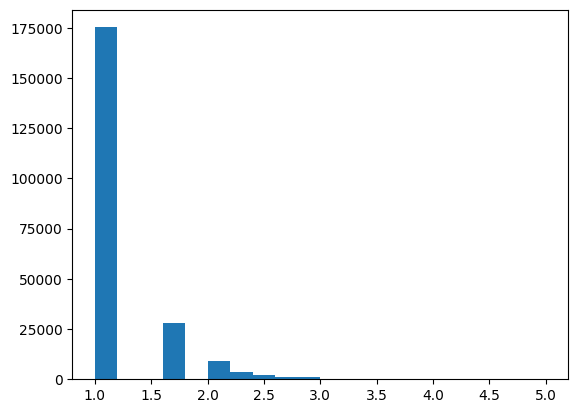

In [108]:
# 1~5 사이의 점수로 변환합니다.
uir_df['Rating'] = uir_df['InvoiceNo'].apply(lambda x: np.log10(x)+1)
uir_df['Rating'] = ((uir_df['Rating'] - uir_df['Rating'].min()) / 
                    (uir_df['Rating'].max() - uir_df['Rating'].min()) * 4) + 1

# 시각화
uir_df['Rating'].hist(bins=20, grid=False)

첫 번째 plot과 비교했을 때는 치우침이 어느정도 개선됨

-----

### 2. SVD 모델 학습하기

In [109]:
# 데이터셋 생성
uir_df = uir_df[['CustomerID', 'StockCode', 'Rating']]
uir_df.head()

,CustomerID,StockCode,Rating
0,12346,23166,1.000000
1,12347,16008,1.000000
2,12347,17021,1.000000
3,12347,20665,1.000000
4,12347,20719,2.048881


In [110]:
import time
from surprise import SVD, Dataset, Reader, accuracy
from surprise.model_selection import train_test_split

# 1. SVD 라이브러리를 사용하기 위한 학습 데이터를 생성합니다. (학습 데이터 : 테스트 데이터 = 8:2)
# 단, 여기서는 아까 처음에 언급했던 test data랑 다름에 유의!

reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(uir_df[['CustomerID', 'StockCode', 'Rating']], reader)
train_data, test_data = train_test_split(data, test_size=0.2)

In [111]:
# 2. SVD 모델을 학습합니다.
train_start = time.time()
model = SVD(n_factors=8,
            lr_all=0.005,
            reg_all=0.02,
            n_epochs=200)
model.fit(train_data)
train_end = time.time()

print("training time of model: %.2f seconds" % (train_end - train_start)) # train하는 데 걸린 시간

training time of model: 10.97 seconds


In [112]:
# 3. 모델평가
predictions = model.test(test_data)
print("RMSE of test dataset in SVD model:")
accuracy.rmse(predictions)

RMSE of test dataset in SVD model:
RMSE: 0.3397


0.3396713683048984

모델의 성능 파악 끝! (RMSE가 낮으면 낮을수록 좋은 것)

-------------------

#### 본격적인 상품 추천 시물레이션 시작

In [115]:
# 1. 11월 "이전" data를 full_trainset으로 설정해서 train!
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(uir_df[['CustomerID', 'StockCode', 'Rating']], reader)
train_data = data.build_full_trainset()

In [116]:
# 2. SVD 모델을 학습합니다.
train_start = time.time()
model = SVD(n_factors=8,
            lr_all=0.005,
            reg_all=0.02,
            n_epochs=200)
model.fit(train_data)
train_end = time.time()
print("training time of model: %.2f seconds" % (train_end - train_start))

training time of model: 6.01 seconds


-----

# <Step3. 예측 평가하기> : 상품 추천 시뮬레이션

### 1. 상품 추천 시뮬레이션

#### 1) 이전에 구매하지 않았던 (신규구매) 상품 추천

In [117]:
test_data = train_data.build_anti_testset() # anti_testset()
target_user_predictions = model.test(test_data) # model : 위에서 만든 SVD 모델

# 구매 예측 결과를 딕셔너리 형태로 변환합니다.
new_order_prediction_dict = {}
for customer_id, stock_code, _, predicted_rating, _ in target_user_predictions:
    if customer_id in new_order_prediction_dict:
        if stock_code in new_order_prediction_dict[customer_id]:
            pass
        else:
            new_order_prediction_dict[customer_id][stock_code] = predicted_rating
    else:
        new_order_prediction_dict[customer_id] = {} 
        new_order_prediction_dict[customer_id][stock_code] = predicted_rating

print(str(new_order_prediction_dict)[:300] + "...")

{'12346': {'16008': 1.004301369537552, '17021': 1.189251370155309, '20665': 1.054169984690685, '20719': 1.5145694617800818, '20780': 1.0162672773835688, '20782': 1.0988300373318878, '20966': 1.0359285403163168, '21035': 1.1131490216026279, '21041': 1.1394782407572126, '21064': 1.041903290487192, '21...


#### 2) 이전에 구매했었던 (재구매) 상품 추천

In [118]:
test_data = train_data.build_testset() # build_testset()
target_user_predictions = model.test(test_data)

# 구매 예측 결과를 딕셔너리 형태로 변환합니다.
reorder_prediction_dict = {}
for customer_id, stock_code, _, predicted_rating, _ in target_user_predictions:
    if customer_id in reorder_prediction_dict:
        if stock_code in reorder_prediction_dict[customer_id]:
            pass
        else:
            reorder_prediction_dict[customer_id][stock_code] = predicted_rating
    else:
        reorder_prediction_dict[customer_id] = {}
        reorder_prediction_dict[customer_id][stock_code] = predicted_rating
        
print(str(reorder_prediction_dict)[:300] + "...")

{'12346': {'23166': 1.0543745260835693}, '12347': {'16008': 1.192881846022818, '17021': 1.1907785113421636, '20665': 1.0182948617289946, '20719': 1.8973180703159191, '20780': 1.0045669439772487, '20782': 1.2257035174494821, '20966': 1.4590659778754875, '21035': 1.3131141503948103, '21041': 1.2753935...


#### 3) 1번과 2번을 통합한(모든 상품 추천) 딕셔너리

In [119]:
total_prediction_dict = {}

# new_order_prediction_dict 정보를 새로운 딕셔너리에 저장합니다.
for customer_id in new_order_prediction_dict:
    if customer_id not in total_prediction_dict:
        total_prediction_dict[customer_id] = {}
    for stock_code, predicted_rating in new_order_prediction_dict[customer_id].items():
        if stock_code not in total_prediction_dict[customer_id]:
            total_prediction_dict[customer_id][stock_code] = predicted_rating
            
# reorder_prediction_dict 정보를 새로운 딕셔너리에 저장합니다.
for customer_id in reorder_prediction_dict:
    if customer_id not in total_prediction_dict:
        total_prediction_dict[customer_id] = {}
    for stock_code, predicted_rating in reorder_prediction_dict[customer_id].items():
        if stock_code not in total_prediction_dict[customer_id]:
            total_prediction_dict[customer_id][stock_code] = predicted_rating
            
print(str(total_prediction_dict)[:300] + "...")

{'12346': {'16008': 1.004301369537552, '17021': 1.189251370155309, '20665': 1.054169984690685, '20719': 1.5145694617800818, '20780': 1.0162672773835688, '20782': 1.0988300373318878, '20966': 1.0359285403163168, '21035': 1.1131490216026279, '21041': 1.1394782407572126, '21064': 1.041903290487192, '21...


In [120]:
# 11월 이후 데이터를 테스트 데이터셋으로 사용하기 위한 데이터프레임을 생성합니다.
simulation_test_df = df_year_end.groupby('CustomerID')['StockCode'].apply(set).reset_index()
simulation_test_df.columns = ['CustomerID', 'RealOrdered']
simulation_test_df.head()

,CustomerID,RealOrdered
0,12347,"{23508, 20719, 21064, 23497, 23271, 21731, 230..."
1,12349,"{85014A, 85014B, 85053, 23460, 21232, 22554, 2..."
2,12352,"{22627, 23089, 23096, 23368, 22668, 21669, 221..."
3,12356,"{21843, 22423}"
4,12357,"{85014A, 21485, 22029, 22890, 21508, 22071, 22..."


In [121]:
# 이 데이터프레임에 상품 추천 시뮬레이션 결과를 추가하기 위한 함수를 정의합니다.
def add_predicted_stock_set(customer_id, prediction_dict):
    if customer_id in prediction_dict:
        predicted_stock_dict = prediction_dict[customer_id]
        # 예측된 상품의 Rating이 높은 순으로 정렬합니다.
        sorted_stocks = sorted(predicted_stock_dict, key=lambda x : predicted_stock_dict[x], reverse=True)
        return sorted_stocks
    else:
        return None

# 상품 추천 시뮬레이션 결과를 추가합니다.
simulation_test_df['PredictedOrder(New)'] = simulation_test_df['CustomerID']. \
                                            apply(lambda x: add_predicted_stock_set(x, new_order_prediction_dict))
simulation_test_df['PredictedOrder(Reorder)'] = simulation_test_df['CustomerID']. \
                                            apply(lambda x: add_predicted_stock_set(x, reorder_prediction_dict))
simulation_test_df['PredictedOrder(Total)'] = simulation_test_df['CustomerID']. \
                                            apply(lambda x: add_predicted_stock_set(x, total_prediction_dict))
simulation_test_df.head()

,CustomerID,RealOrdered,PredictedOrder(New),PredictedOrder(Reorder),PredictedOrder(Total)
0,12347,"{23508, 20719, 21064, 23497, 23271, 21731, 230...","[85099B, 22383, 20727, 23199, 20725, 47566, 20...","[21731, 22371, 22728, 20719, 21975, 84991, 227...","[85099B, 22383, 20727, 23199, 20725, 47566, 20..."
1,12349,"{85014A, 85014B, 85053, 23460, 21232, 22554, 2...",None,None,None
2,12352,"{22627, 23089, 23096, 23368, 22668, 21669, 221...","[85131B, 84086B, 90119, 85123A, 90035A, 20679,...","[22779, 22780, 84050, 37448, 22413, 22423, 227...","[85131B, 84086B, 90119, 85123A, 22779, 90035A,..."
3,12356,"{21843, 22423}","[84086B, 90119, 85131B, 90042A, 90035A, 85099B...","[21843, 22423, 22699, 22698, 21213, 84991, 843...","[84086B, 90119, 85131B, 90042A, 90035A, 85099B..."
4,12357,"{85014A, 21485, 22029, 22890, 21508, 22071, 22...",None,None,None


-----

### 상품 추천 평가하기

Ch.4에서 봤던 재현도(Recall)와 동일한 개념

#### 평가 기준 정의하기

In [122]:
# 구매 예측의 상위 k개의 Recall(재현율)을 평가 기준으로 정의합니다.

def calculate_recall(real_order, predicted_order, k):
    # 만약 추천 대상 상품이 없다면, 11월 이후에 상품을 처음 구매하는 유저입니다.
    if predicted_order is None:
        return None
    
    # 1. 유저별로 예측된 상품의 점수 순으로 상위 k개의 상품을 추천 대상으로 정의
    predicted = predicted_order[:k]
    true_positive = 0
    for stock_code in predicted:
        if stock_code in real_order:
            true_positive += 1
    
    # 2. 추천한 k개의 상품 중, 실제 구매로 이어진 정도 파악
    recall = true_positive / len(predicted)
    return recall

In [126]:
# 추천할 상품 5개 추려서 알려주기
simulation_test_df['top_k_recall(Reorder)'] = simulation_test_df. \
                                                apply(lambda x: calculate_recall(x['RealOrdered'], 
                                                                                 x['PredictedOrder(Reorder)'], 
                                                                                 5), axis=1)
simulation_test_df['top_k_recall(New)'] = simulation_test_df. \
                                                apply(lambda x: calculate_recall(x['RealOrdered'], 
                                                                                 x['PredictedOrder(New)'], 
                                                                                 5), axis=1)
simulation_test_df['top_k_recall(Total)'] = simulation_test_df. \
                                                apply(lambda x: calculate_recall(x['RealOrdered'], 
                                                                                 x['PredictedOrder(Total)'], 
                                                                                 5), axis=1)

In [127]:
# 평가 결과를 유저 평균으로 살펴봅니다.
print(simulation_test_df['top_k_recall(Reorder)'].mean())
print(simulation_test_df['top_k_recall(New)'].mean())
print(simulation_test_df['top_k_recall(Total)'].mean())

0.31659090909090903
0.006363636363636364
0.06675324675324676


재구매 상품추천 > 신규구매 상품추천

-----------------

#### 세부 결과

#### 1) 재구매

In [131]:
simulation_test_df['top_k_recall(Reorder)'].value_counts()

0.000000    456
0.200000    408
0.400000    264
0.600000    192
0.800000    123
1.000000     78
0.500000      7
0.250000      6
0.666667      4
0.750000      1
0.333333      1
Name: top_k_recall(Reorder), dtype: int64

#### 2) 신규구매

In [132]:
simulation_test_df['top_k_recall(New)'].value_counts()

0.0    1495
0.2      41
0.4       4
Name: top_k_recall(New), dtype: int64

#### 3) 전체

In [133]:
simulation_test_df['top_k_recall(Total)'].value_counts()

0.0    1221
0.2     200
0.4      69
0.6      28
0.8      18
1.0       4
Name: top_k_recall(Total), dtype: int64

재구매 상품추천 > 신규구매 상품추천

-----------------

In [53]:
# SVD 모델의 추천기준에 부합하지 않는 유저를 추출합니다.
not_recommended_df = simulation_test_df[simulation_test_df['PredictedOrder(Reorder)'].isnull()]
print(not_recommended_df.shape)
not_recommended_df.head()

(364, 8)


,CustomerID,RealOrdered,PredictedOrder(New),PredictedOrder(Reorder),PredictedOrder(Total),top_k_recall(Reorder),top_k_recall(New),top_k_recall(Total)
1,12349,"{21086, 23240, 22556, 37448, 85014B, 21787, 22...",None,None,None,NaN,NaN,NaN
4,12357,"{21116, 22718, 22023, 23197, 35599B, 21485, 72...",None,None,None,NaN,NaN,NaN
8,12367,"{21579, 21770, 22708, 22631, 22045, 85227, 162...",None,None,None,NaN,NaN,NaN
9,12374,"{22734, 23353, 23354, 22732, 23497, 22144, 221...",None,None,None,NaN,NaN,NaN
15,12391,"{22144, 21841, 21126, 22816, 22809, 23197, 209...",None,None,None,NaN,NaN,NaN


-----

#### 결과를 데이터프레임으로 만들기

In [54]:
# 추천 시뮬레이션 결과를 살펴봅니다.
k = 5
result_df = simulation_test_df[simulation_test_df['PredictedOrder(Reorder)'].notnull()]
result_df['PredictedOrder(Reorder)'] = result_df['PredictedOrder(Reorder)'].\
                                                        apply(lambda x: x[:k])
result_df = result_df[['CustomerID', 'RealOrdered', 
                       'PredictedOrder(Reorder)', 'top_k_recall(Reorder)']]
result_df.columns = [['구매자ID', '실제주문', '5개추천결과', 'Top5추천_주문재현도']]
result_df.sample(5).head()

,구매자ID,실제주문,5개추천결과,Top5추천_주문재현도
1053,15608,"{23310, 35970}","[22383, 82486, 22752, 21833, 84945]",0.0
723,14592,"{22476, 21787, 22209, 22530, 22112, 21135, 231...","[22197, 22712, 84988, 22993, 21080]",0.0
998,15467,"{22594, 23215, 84347, 22593, 23213, 22178, 221...","[22178, 23298, 22588, 22477, 21124]",0.2
1800,17949,"{22197, 23108}","[22197, 22423, 22699, 23170, 23171]",0.2
1781,17883,"{21365, 23376, 22755, 84550, 23169, 21864, 219...","[82482, 47566, 21928, 21463, 22699]",0.0
